In [66]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!pip install transformers
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.26.1-py3-none-any.whl (6.3 MB)
  Using cached tokenizers-0.13.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
  Using cached huggingface_hub-0.12.1-py3-none-any.whl (190 kB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
clipped_data_2018 = pd.read_csv('https://raw.githubusercontent.com/Rising-Stars-by-Sunshine/ColdenJohnson-stats201-Final-Project/main/data/Queried_Data/Final_Project_ExpandedCausalityTimePeriod.csv')

# https://raw.githubusercontent.com/Rising-Stars-by-Sunshine/ColdenJohnson-stats201-Final-Project/main/data/Queried_Data/clipped_trump_data_2018.csv
# https://raw.githubusercontent.com/Rising-Stars-by-Sunshine/ColdenJohnson-stats201-Final-Project/main/data/Queried_Data/Final_Project_ExpandedCausalityTimePeriod.csv

In [5]:
clipped_data_2018['rawContent'] = clipped_data_2018['rawContent'].astype(str)

tweets_to_process = []
for item in clipped_data_2018['rawContent']:
  tweets_to_process.append(item)

In [6]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [8]:
tweet_proc_list = []
for tweet in tweets_to_process:
  # preprocess tweet
  tweet_words = []
  for word in tweet.split(' '):
    if word.startswith('@') and len(word) > 1:
      word = '@user'
    elif word.startswith('http'):
      word = 'http'
    tweet_words.append(word)
    tweet_proc = ' '.join(tweet_words)
  tweet_proc_list.append(tweet_proc)

In [9]:
# get model roberta -- trained on 58 million tweets for sentiment analysis
# This is a deep learning model
# cite this paper https://aclanthology.org/2020.findings-emnlp.148/
roberta = 'cardiffnlp/twitter-roberta-base-sentiment'
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

labels = ['Negative', 'Neutral', 'Positive']

In [10]:
# sentiment analysis
scores_list = []
for tweet_proc in tweet_proc_list:
  encoded_tweet = tokenizer(tweet_proc, return_tensors = 'pt')
  # output = model(encoded_tweet['input_ids'], encoded_tweet['attention_mask'])
  output = model(**encoded_tweet)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_list.append(scores)
  # for i in range(len(scores)):
  #   l = labels[i]
  #   s = scores[i]
  #   print(l, s)
clipped_data_2018['scores'] = scores_list

In [11]:
print(clipped_data_2018)

       Unnamed: 0                                         rawContent  \
0           38244  Never Told Story,but Swear It’s True🤚🏼.Have To...   
1           38245  Biden to CBS on Trump: "What value is giving h...   
2           38246  JUST IN: Biden says Trump shouldn't get intel ...   
3           38247  President Biden tells @NorahODonnell that form...   
4           38248  BREAKING REPORT: MSNBC Host Nicolle Wallace SU...   
...           ...                                                ...   
28658        7325  Raphael Warnock asks Kelly Loeffler point blan...   
28659        7326  "Radical liberal" third time in 12 minutes.\n\...   
28660        7327  Kelly Loeffler not answering directly when ask...   
28661        7328  The people of Georgia have spoken. Donald Trum...   
28662        7329  Kelly Loeffler won't affirm the reality that T...   

                            Date  replyCount  retweetCount  likeCount  \
0      2021-02-05 23:51:55+00:00         696           765    

In [12]:
sentiment_num_list = []
sentiment_int_list = []
for tweet_num in range(len(scores_list)):
  neg = clipped_data_2018['scores'][tweet_num][0]
  neut = clipped_data_2018['scores'][tweet_num][1]
  pos = clipped_data_2018['scores'][tweet_num][2]
  largest = max(neg, neut, pos)
  if neg == largest:
    sentiment_num_list.append('neg')
    sentiment_int_list.append(-1)
  elif neut == largest:
    sentiment_num_list.append('neut')
    sentiment_int_list.append(0)
  elif pos == largest:
    sentiment_num_list.append('pos')
    sentiment_int_list.append(1)

clipped_data_2018['sentiment_str_type'] = sentiment_num_list
clipped_data_2018['sentiment_int_type'] = sentiment_int_list

In [13]:
print(clipped_data_2018)

       Unnamed: 0                                         rawContent  \
0           38244  Never Told Story,but Swear It’s True🤚🏼.Have To...   
1           38245  Biden to CBS on Trump: "What value is giving h...   
2           38246  JUST IN: Biden says Trump shouldn't get intel ...   
3           38247  President Biden tells @NorahODonnell that form...   
4           38248  BREAKING REPORT: MSNBC Host Nicolle Wallace SU...   
...           ...                                                ...   
28658        7325  Raphael Warnock asks Kelly Loeffler point blan...   
28659        7326  "Radical liberal" third time in 12 minutes.\n\...   
28660        7327  Kelly Loeffler not answering directly when ask...   
28661        7328  The people of Georgia have spoken. Donald Trum...   
28662        7329  Kelly Loeffler won't affirm the reality that T...   

                            Date  replyCount  retweetCount  likeCount  \
0      2021-02-05 23:51:55+00:00         696           765    

1579


Text(0.5, 1.0, 'Sentiment Distribution')

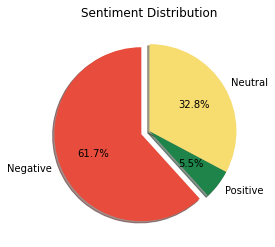

In [14]:
import matplotlib.pyplot as plt
# Get relative counts of pos and neg for pychart
count_neg = (clipped_data_2018['sentiment_str_type'] == 'neg').sum()
count_neut = (clipped_data_2018['sentiment_str_type'] == 'neut').sum()
count_pos = (clipped_data_2018['sentiment_str_type'] == 'pos').sum()
print(count_pos)



# Data to plot
labels = ['Negative', 'Positive', 'Neutral']
sizes = [count_neg, count_pos, count_neut]
colors = ['#E74C3C', '#1E8449', '#F7DC6F']

# Plot data
plt.pie(sizes,
labels =labels,
colors = colors,
startangle = 90,
shadow = True,
explode =(0.1,0,0),
autopct ='%1.1f%%')
plt.title('Sentiment Distribution')


<AxesSubplot:title={'center':'Average Tweet Sentiment (Scale between -1 to +1)'}, xlabel='timestamp'>

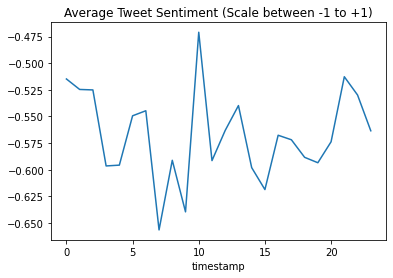

In [39]:
# Convert 'date' column to datetime format
clipped_data_2018['timestamp'] = pd.to_datetime(clipped_data_2018['Date'])

# Group the data by day and calculate the mean of each day
# replace 'hour' with 'date' to group by day instead
# daily_average = clipped_data_2018.groupby(clipped_data_2018['timestamp'].dt.date)['likeCount'].mean()
daily_average = clipped_data_2018.groupby(clipped_data_2018['timestamp'].dt.hour)['sentiment_int_type'].mean()

# Create a line chart of the daily average data over time
plot = daily_average.plot()


# plot.axvline(x = 8, color='green')
plot.set_title('Average Tweet Sentiment (Scale between -1 to +1)')
plot



<AxesSubplot:title={'center':'Average Tweet Sentiment (Scale between -1 to +1)'}, xlabel='timestamp'>

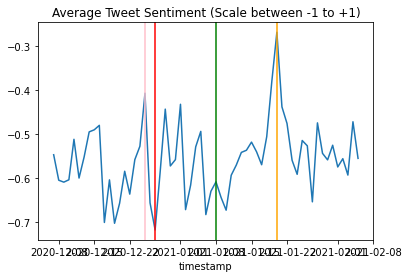

In [65]:
# Group the data by day and calculate the mean of each day
# replace 'hour' with 'date' to group by day instead
# daily_average = clipped_data_2018.groupby(clipped_data_2018['timestamp'].dt.date)['likeCount'].mean()
daily_average = clipped_data_2018.groupby(clipped_data_2018['timestamp'].dt.date)['sentiment_int_type'].mean()
plot = daily_average.plot(kind='line')

# Trump blocked the democratic stimulus bill
jan6 = pd.Timestamp('2020-12-25')
plt.axvline(x=jan6, color='pink')

# Trump averts government shutdown by signing coronavirus relief bill into law - very much disliked by his base
jan6 = pd.Timestamp('2020-12-27')
plt.axvline(x=jan6, color='red')

# Jan 6 riots
jan6 = pd.Timestamp('2021-01-08')
plot.axvline(x=jan6, color='green')

# Trump concedes presidency to Biden
jan6 = pd.Timestamp('2021-01-20')
plt.axvline(x=jan6, color='orange')


plot.set_title('Average Tweet Sentiment (Scale between -1 to +1)')
plot



Text(0.5, 0, 'Date')

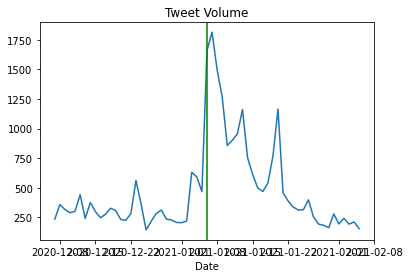

In [19]:
# Tweet Volume
daily_average = clipped_data_2018.groupby(clipped_data_2018['timestamp'].dt.date)['rawContent'].count()
plot = daily_average.plot(kind='line')

jan6 = pd.Timestamp('2021-01-06')
plot.axvline(x=jan6, color='green')
plot.set_title('Tweet Volume')
plot.set_xlabel('Date')


In [1]:
# Tweet Volume
daily_average = clipped_data_2018.groupby(clipped_data_2018['timestamp'].dt.hour)['rawContent'].count()
plot = daily_average.plot()

# jan6 = pd.Timestamp('2021-01-06')
# plot.axvline(x=jan6, color='green')
# plot.axvline(x = 8, color='green')
plot.set_title('Tweet Volume')
plot

NameError: ignored

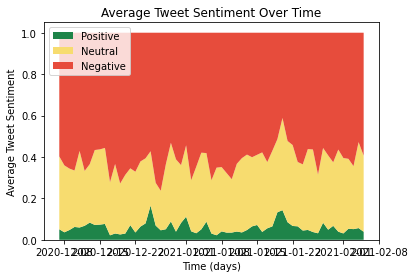

In [23]:
# Group the data by hour and count the number of tweets in each sentiment category
hourly_sentiment_counts = clipped_data_2018.groupby([pd.Grouper(key='timestamp', freq='D'), 'sentiment_str_type'])['rawContent'].count().unstack(fill_value=0)

# Calculate the percentage of tweets in each sentiment category for each hour
hourly_sentiment_percentages = hourly_sentiment_counts.div(hourly_sentiment_counts.sum(axis=1), axis=0)

# Plot the stacked area chart
plt.stackplot(hourly_sentiment_percentages.index, hourly_sentiment_percentages['pos'], hourly_sentiment_percentages['neut'], hourly_sentiment_percentages['neg'], labels=['Positive', 'Neutral', 'Negative'], colors = ['#1E8449', '#F7DC6F', '#E74C3C'])
plt.legend(loc='upper left')
plt.xlabel('Time (days)')
plt.ylabel('Average Tweet Sentiment')
plt.title('Average Tweet Sentiment Over Time')

# Show the plot
plt.show()

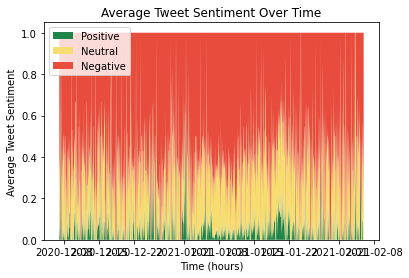

In [26]:
# Group the data by hour and count the number of tweets in each sentiment category
hourly_sentiment_counts = clipped_data_2018.groupby([pd.Grouper(key='timestamp', freq='H'), 'sentiment_str_type'])['rawContent'].count().unstack(fill_value=0)

# Calculate the percentage of tweets in each sentiment category for each hour
hourly_sentiment_percentages = hourly_sentiment_counts.div(hourly_sentiment_counts.sum(axis=1), axis=0)

# Plot the stacked area chart
plt.stackplot(hourly_sentiment_percentages.index, hourly_sentiment_percentages['pos'], hourly_sentiment_percentages['neut'], hourly_sentiment_percentages['neg'], labels=['Positive', 'Neutral', 'Negative'], colors = ['#1E8449', '#F7DC6F', '#E74C3C'])
plt.legend(loc='upper left')
plt.xlabel('Time (hours)')
plt.ylabel('Average Tweet Sentiment')
plt.title('Average Tweet Sentiment Over Time')

# Show the plot
plt.show()

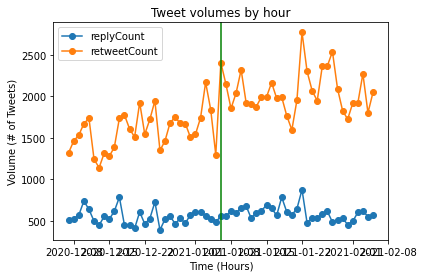

In [49]:
# Convert 'timestamp' column to datetime format
clipped_data_2018['timestamp'] = pd.to_datetime(clipped_data_2018['timestamp'])

# Create a new column 'hour' that contains the hour of the timestamp
clipped_data_2018['hour'] = clipped_data_2018['timestamp'].dt.date

# Group the data by hour and calculate the mean of each group
hourly_mean = clipped_data_2018.groupby('hour').mean()

# Create a spaghetti plot of the three columns
hourly_mean.plot(y=['replyCount', 'retweetCount'], style='-o')

jan6 = pd.Timestamp('2021-01-06')
plt.axvline(x=jan6, color='green')

# Set the title and axis labels
plt.title('Tweet volumes by hour')
plt.xlabel('Time (Hours)')
plt.ylabel('Volume (# of Tweets)')

# Show the plot
plt.show()


In [28]:
!pip install pyLDAvis
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 70.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim

In [30]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
stopwords.add('http')
stopwords.add('https')
stopwords.add('co')
print(stopwords)


{"needn't", 'being', 'll', "she's", "shouldn't", 'some', 'why', 'their', 'been', 'are', "shan't", 'only', 'themselves', 'didn', 'she', 'isn', 'm', 'as', 'doing', "won't", 'should', 'aren', 'herself', 'between', 'his', 'theirs', 're', 'both', "wasn't", "you'll", 'o', 'which', 'haven', 'it', 'be', 'you', 'a', 'hadn', 'after', 'these', 'shouldn', 'this', 'had', 'such', 'above', "mustn't", 'or', "hasn't", 'our', 'into', "should've", 'own', 't', 'co', 'd', 'too', 'at', 'against', 'because', "couldn't", 'don', 'her', 'where', 'can', 'each', 'its', 'off', 'the', 'yours', 'so', 'will', 'http', 'were', 'there', 'up', "aren't", 'few', "doesn't", 'ours', 'while', 'about', 'from', 'needn', 'during', 'who', 'any', 'if', 'then', 'not', 'itself', 'down', 'out', 'ain', "haven't", "isn't", 'by', 'just', "weren't", 'further', 'does', "you've", 'ma', "mightn't", 'weren', 'over', 'ourselves', 've', 'yourselves', 'me', 'have', 'my', 'other', "you'd", 'y', 'than', 'mightn', 'was', 'yourself', 'myself', "you

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Wordcloud for Trump Data Query


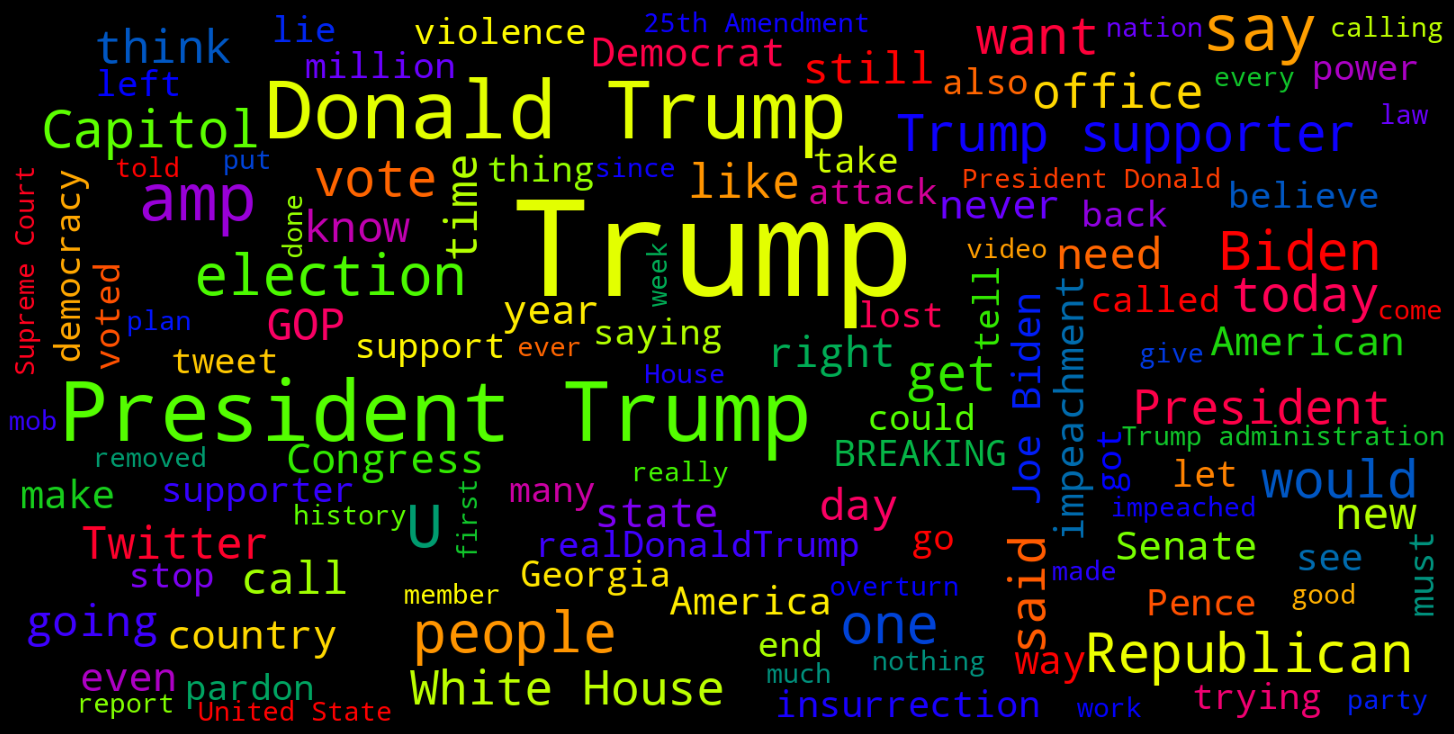

In [31]:
from wordcloud import WordCloud, STOPWORDS

# word cloud visualization
def word_cloud(text):
    allWords = ' '.join([twts for twts in text])
    wordCloud = WordCloud(background_color='black',width = 1600, height = 800,stopwords = stopwords,min_font_size = 30,max_font_size=150,colormap='prism').generate(allWords)
    fig, ax = plt.subplots(figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad=0)
    plt.show()

print('Wordcloud for Trump Data Query')
word_cloud(clipped_data_2018['rawContent'].values)

In [32]:
# now lemmatize text for processing
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    words_output = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
          # only allowed postags will be appended (noun, adj, verb, adv)
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        words_output.append(final)
    return (words_output)

lemmatized_texts = lemmatization(tweet_proc_list)

In [33]:
# create function to remove stopwords
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        new = [x for x in new if x != 'http' and x != 'just' and x != 'go'and x != 'say'and x != 'more'and x != 'get'and x != 'call']
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)
print (data_words[0])



['never', 'tell', 'true', 'so', 'try', 'things', 'night', 'see', 'amp', 'order', 'sleep', 'so', 'send', 'back', 'think', 'see', 'trump', 'still', 'keep', 'care', 'pillow']


In [34]:
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['never', 'tell', 'true', 'so', 'try', 'things', 'night', 'see', 'amp', 'order', 'sleep', 'so', 'send', 'back', 'think', 'see', 'trump', 'still', 'keep', 'care']


In [35]:
# remove words that aren't useful in topics
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

# not sure about this-- should check what is being dropped vs not
low_value = 0.03
words = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    for item in drops:
      words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


In [36]:
# id2word = corpora.Dictionary(data_words)

# corpus = []
# for text in data_words:
#     new = id2word.doc2bow(text)
#     corpus.append(new)

# # tuple list corresponds to index in dict. and frequency of word - much quicker to run this model on
# print (corpus[0][0:5])

In [37]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning) # ignore warning that is driving me crazy

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                            # should probably change num_topics
                                           num_topics=10,
                                           random_state=100,
                                            # can maybe increase this to make the model run quicker?
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [38]:
# generate some graphs for data
pyLDAvis.enable_notebook()
# also can update R term to decrease num included
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=5)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.208406  0.407680       1        1  19.466255
6      0.142504 -0.402786       2        1  11.874419
0      0.220197  0.406499       3        1  11.370190
8     -0.204363 -0.376060       4        1   9.730339
2     -0.347245  0.139792       5        1   8.834720
4      0.069863  0.186080       6        1   8.569240
5      0.355417 -0.185750       7        1   8.341385
7     -0.386515 -0.123235       8        1   8.131788
1      0.383247  0.077252       9        1   7.942973
9     -0.024700 -0.129472      10        1   5.738690, topic_info=                Term          Freq         Total Category  logprob  loglift
17             trump  13012.000000  13012.000000  Default   5.0000   5.0000
76          election   4364.000000   4364.000000  Default   4.0000   4.0000
52              vote   2453.000000   2453.000000  Default   3.0000   3.0000
89            people   2355.000000   2355.000000  Default   2.0000   2.0000
61              lose   2254.000000   2254.000000  Default   1.0000   1.0000
17             trump  13011.224520  13012.056832   Topic1  -1.5800   1.6364
103              now   2642.419858   2643.252191   Topic1  -3.1741   1.6362
11                so   1721.250307   1722.082623   Topic1  -3.6028   1.6360
484             know   1314.199482   1315.031800   Topic1  -3.8726   1.6359
488             time   1261.118179   1261.950502   Topic1  -3.9138   1.6358
89            people   2354.243479   2355.067330   Topic2  -2.7953   2.1304
47              make   1573.304849   1574.128707   Topic2  -3.1983   2.1303
250              day   1150.239460   1151.063309   Topic2  -3.5116   2.1301
49             right    999.309820   1000.133681   Topic2  -3.6522   2.1300
193           office    866.315959    867.139857   Topic2  -3.7950   2.1298
76          election   4364.018394   4364.864536   Topic3  -2.1347   2.1740
61              lose   2253.763903   2254.610057   Topic3  -2.7955   2.1738
509              win   1804.091941   1804.938086   Topic3  -3.0181   2.1737
13              tell   1014.024078   1014.870177   Topic3  -3.5942   2.1733
174             need    894.203469    895.049599   Topic3  -3.7200   2.1732
365              ask    922.539037    923.371185   Topic4  -3.5330   2.3290
231             many    737.365557    738.197613   Topic4  -3.7571   2.3288
286            claim    724.827037    725.659115   Topic4  -3.7742   2.3288
736            legal    597.799744    598.631881   Topic4  -3.9669   2.3285
931       government    492.090958    492.923022   Topic4  -4.1615   2.3282
399            state   1958.646557   1959.479602   Topic5  -2.6836   2.4261
146             take   1207.497512   1208.330456   Topic5  -3.1673   2.4258
190         https_co    970.883805    971.716741   Topic5  -3.3854   2.4256
31          breaking    794.850342    795.683290   Topic5  -3.5854   2.4254
125          country    702.590992    703.423917   Topic5  -3.7088   2.4253
96              want   1262.427389   1263.258663   Topic6  -3.0923   2.4563
267          vaccine   1107.986781   1108.818207   Topic6  -3.2228   2.4562
597            today   1045.957110   1046.788408   Topic6  -3.2804   2.4562
8                see    868.235201    869.066505   Topic6  -3.4666   2.4560
599         american    691.323799    692.155096   Topic6  -3.6945   2.4558
960            leave   1298.910043   1299.736012   Topic7  -3.0368   2.4833
122        supporter   1222.518594   1223.344546   Topic7  -3.0975   2.4833
453          support    920.255645    921.081578   Topic7  -3.3815   2.4830
797        democracy    867.725666    868.551618   Topic7  -3.4402   2.4830
35               use    785.891846    786.717798   Topic7  -3.5393   2.4829
155             year   1266.789258   1267.624227   Topic8  -3.0364   2.5087
911         official    939.878321    940.713371   Topic8  -3.3349   2.5085
1289  administration    838.714074    839